In [0]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

np.random.seed(42)

In [0]:
class pwld_interp1d:
    def __init__(self, x, y, sigma=1.):
        n = len(x)
        dy = np.random.normal(0, sigma, n)
        self.y = np.stack([y + dy, y]).flatten('F')
        self.x = np.stack([x, x]).flatten('F')
        self.interp = interp1d(self.x, self.y, kind='linear')
    
    def __call__(self, y):
        return self.interp(y)

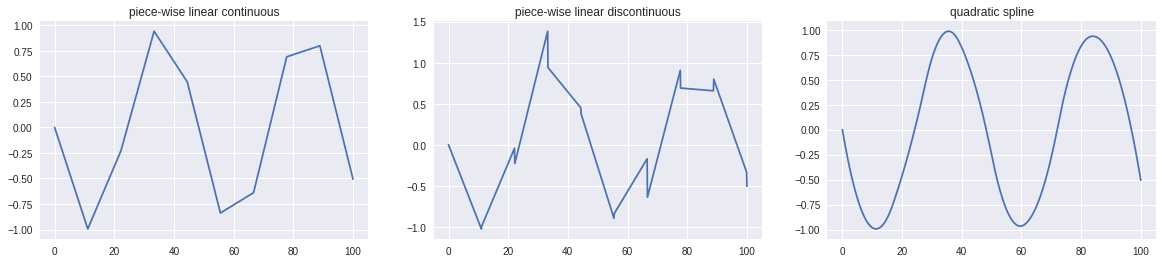

In [3]:
import scipy.interpolate as sp
import numpy
import matplotlib.pyplot as plt


x = numpy.linspace(0, 100, 10)
y = numpy.sin(x)

# interpolation
f1 = sp.interp1d(x, y, kind='linear')
f2 = pwld_interp1d(x, y, sigma=0.3)
f3 = sp.interp1d(x, y, kind='quadratic')


fig, ax = plt.subplots(1,3, figsize=(20,4))
xnew = numpy.linspace(0, 100, 1000)

ax[0].set_title('piece-wise linear continuous')
ax[0].plot(xnew, f1(xnew))

ax[1].set_title('piece-wise linear discontinuous')
ax[1].plot(xnew, f2(xnew), '-')

ax[2].set_title('quadratic spline')
ax[2].plot(xnew, f3(xnew), '-')

plt.show()

2.Add some noise to the signal:

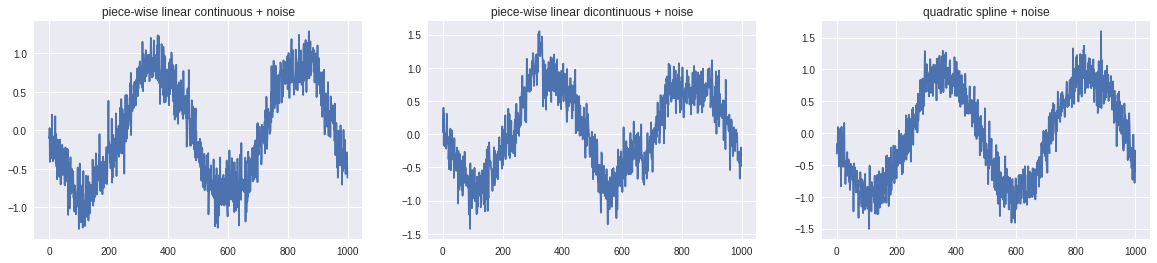

In [4]:
fig, ax = plt.subplots(1,3, figsize=(20,4))

linear_continuous_signal = f1(xnew) + np.random.normal(size=xnew.shape[0]) * 0.2
ax[0].set_title('piece-wise linear continuous + noise')
ax[0].plot(linear_continuous_signal)


linear_discontinuous_signal = f2(xnew) + np.random.normal(size=xnew.shape[0]) * 0.2
ax[1].set_title('piece-wise linear dicontinuous + noise')
ax[1].plot(linear_discontinuous_signal)

quadratic_signal = f3(xnew) + np.random.normal(size=xnew.shape[0]) * 0.2
ax[2].set_title('quadratic spline + noise')
ax[2].plot(quadratic_signal)

3. Recovery procedure

In [0]:
n = xnew.shape[0]
D1 = np.zeros((n-1,n))
i,j = np.indices(D1.shape)
D1[i==j] = 1.
D1[i==j-1] = -1.

In [0]:
n = xnew.shape[0]
D2 = np.zeros((n-2,n))
i,j = np.indices(D2.shape)
D2[i==j] = 1.
D2[i==j-1] = -2.
D2[i==j-2] = 1.

In [0]:
import cvxpy as cp

In [60]:
f1_recovery = cp.Variable(n)
func = cp.norm(f1_recovery - linear_continuous_signal, p=2) + cp.norm(D1 * f1_recovery, p=2)
problem = cp.Problem(cp.Minimize(func))
problem.solve()

6.019025976565587

In [61]:
f2_recovery = cp.Variable(n)
func = cp.norm(f2_recovery - linear_discontinuous_signal, p=2) + cp.norm(D1 * f2_recovery, p=1)
problem = cp.Problem(cp.Minimize(func))
problem.solve()

11.997580199137118

In [62]:
f3_recovery = cp.Variable(n)
func = cp.norm(f3_recovery - quadratic_signal, p=2) + cp.norm(D2 * f3_recovery, p=1)
problem = cp.Problem(cp.Minimize(func))
problem.solve()

6.218727220538134

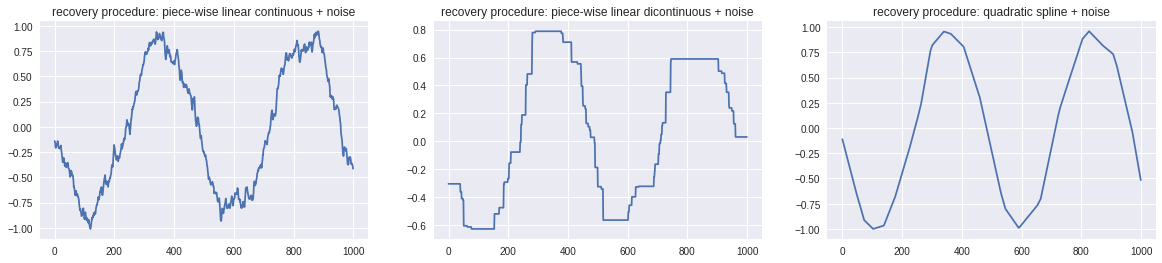

In [63]:
fig, ax = plt.subplots(1,3, figsize=(20,4))

ax[0].set_title('recovery procedure: piece-wise linear continuous + noise')
ax[0].plot(f1_recovery.value)

ax[1].set_title('recovery procedure: piece-wise linear dicontinuous + noise')
ax[1].plot(f2_recovery.value)

ax[2].set_title('recovery procedure: quadratic spline + noise')
ax[2].plot(f3_recovery.value)

4.Dependancy on $\gamma$.

In [0]:
gammas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

f1_values = []
f2_values = []
f3_values = []

In [0]:
for gamma in gammas:
  f1_recovery = cp.Variable(n)
  func = cp.norm(f1_recovery - linear_continuous_signal, p=2) + gamma*cp.norm(D1 * f1_recovery, p=2)
  problem = cp.Problem(cp.Minimize(func))
  problem.solve()
  f1_values.append(f1_recovery)
  
  f2_recovery = cp.Variable(n)
  func = cp.norm(f2_recovery - linear_discontinuous_signal, p=2) + gamma*cp.norm(D1 * f2_recovery, p=2)
  problem = cp.Problem(cp.Minimize(func))
  problem.solve()
  f2_values.append(f2_recovery)
  
  f3_recovery = cp.Variable(n)
  func = cp.norm(f3_recovery - quadratic_signal, p=2) + gamma*cp.norm(D2 * f3_recovery, p=2)
  problem = cp.Problem(cp.Minimize(func))
  problem.solve()
  f3_values.append(f3_recovery)

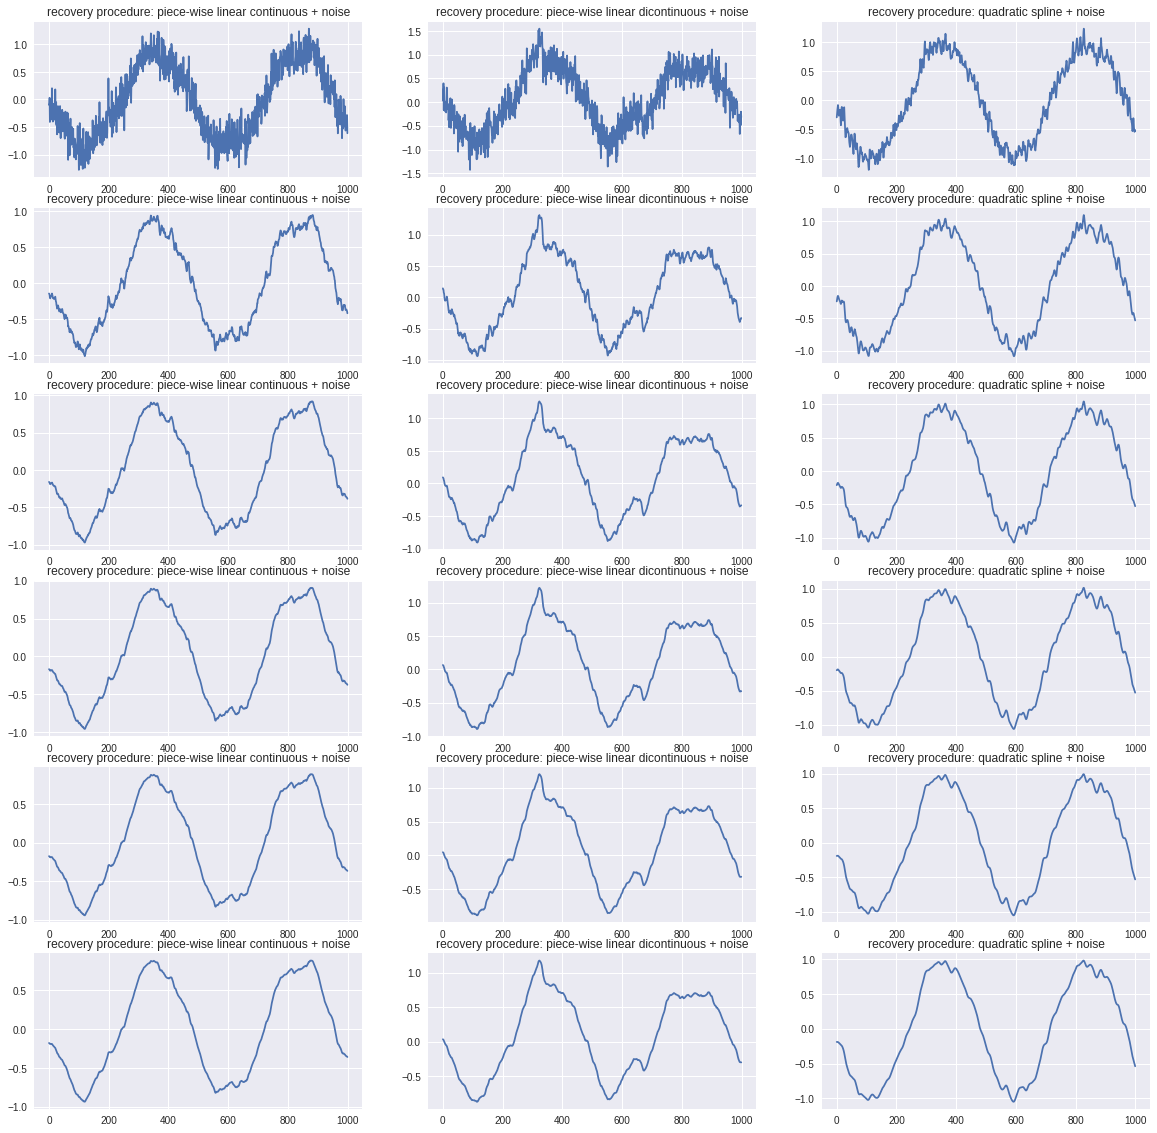

In [15]:
fig, ax = plt.subplots(6,3, figsize=(20,20))
# j = 0
for j in range(6):
  ax[j,0].set_title('recovery procedure: piece-wise linear continuous + noise')
  ax[j,0].plot(f1_values[j].value)

  ax[j,1].set_title('recovery procedure: piece-wise linear dicontinuous + noise')
  ax[j,1].plot(f2_values[j].value)

  ax[j,2].set_title('recovery procedure: quadratic spline + noise')
  ax[j,2].plot(f3_values[j].value)
#   j += 1
plt.show()

It looks like the bigger value of $\gamma$  shows better results.

#### Task 2

##### Solution:

In this task, an ellipsoid $\mathbb E$ in $R^d$ can be described in the following way:
$$
\mathbb E=\{x \in R^d | (x-c)^T P^{-1} (x-c) \leq 1\}
$$

$$\Rightarrow$$

$$
\mathbb E=\{x \in R^d | 1 - (x-c)^T P^{-1} (x-c) \geq 0\}
$$

Using Schur complement form, there is a possibility to to describe an ellipsoid expression as LMI:

$$
\mathbb E = \begin{pmatrix} 1 & (x-c)^T\\ x-c & P \end{pmatrix}
$$

If we consider a point $a$ in the ellipsoid then the expression is changed in the following form:

$$
\mathbb E = \begin{pmatrix} 1 & (a-c)^T\\ a-c & P \end{pmatrix}
$$

#### Task 3

##### Solution:

In [0]:
import matplotlib.pyplot as plt
import cvxopt.lapack as lp
from matplotlib.patches import Ellipse
from itertools import combinations
import math
%matplotlib inline
import cvxpy as cvp

In [0]:
def show_ellipse(X,fig,ax, A, b, color,show_plot,k=None,scatter_colot='red'):
    if k is None:
        k = len(X)
    sigma = np.linalg.inv(A.T.dot(A))
    mu = -sigma.dot(A.T).dot(b)
    vals, vecs = np.linalg.eigh(sigma)

    x, y = vecs[:, 0]
    theta = np.degrees(np.arctan2(y, x))

    w, h = 2 * np.sqrt(vals)
    ellipse = Ellipse(mu, w, h, theta, color=color)
    ellipse.set_clip_box(ax.bbox)
    ellipse.set_alpha(0.2)
    ax.add_artist(ellipse)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.scatter(X.T[0], X.T[1], color=scatter_colot)
    plt.grid(color='lightgray', linestyle='--')
    if show_plot:
        plt.title("k: "+str(k)+" count:"+str(count))
        plt.show()

In [0]:
def solve(x,fig, ax,plot=True,show_plot=True,color="b"):
    global count
    count+=1
    n, m = x.shape
    A = cvp.Variable((m, m), PSD=True)
    b = cvp.Variable((m))
    constraints_s = [cvp.norm((x * A)[i] + b) <= 1 for i in np.arange(0,n,1)]

    obj_s = cvp.Minimize(-cvp.log_det(A))
    prob = cvp.Problem(obj_s, constraints_s)
    try:
        prob.solve(solver=cvp.CVXOPT)
    except:
        return None,None,np.inf
    if plot:    
        show_ellipse(x,fig,ax, A.value, b.value, color,show_plot)
    return A.value,b.value,prob.value

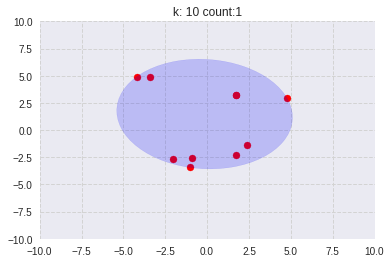

3


In [56]:
points = 10
n, m = 10,2
count = 0
x = np.random.rand(n,m)*points-5
fig, ax= plt.subplots()
A,b,cost = solve(x,fig, ax)
print(np.argmin([np.linalg.norm(A.dot(x[i]) + b,2) for i in np.arange(0,n,1)]))

In [32]:
print("A value: ",A)
print("b value: ",b)

A value:  [[0.16735078 0.03931651]
 [0.03931651 0.24500518]]
b value:  [ 0.25349144 -0.05480058]
